In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
raw = pd.read_csv("all1.csv")
raw.info()
data = raw.drop(raw.columns.values[0], axis=1)
data = data.fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37617 entries, 0 to 37616
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Index            37617 non-null  int64  
 1   Price            36924 non-null  float64
 2   Description      37148 non-null  object 
 3   Kind             37617 non-null  object 
 4   Location         37617 non-null  object 
 5   Size             37591 non-null  float64
 6   Parking_slot     13480 non-null  float64
 7   Air_condition    16624 non-null  float64
 8   Heater_shower    13175 non-null  float64
 9   Furnish          12529 non-null  float64
 10  Inner_toilet     9299 non-null   float64
 11  Size_total_bool  5539 non-null   float64
 12  Source           37617 non-null  object 
 13  ward             37617 non-null  object 
 14  district         37617 non-null  object 
 15  province         37617 non-null  object 
 16  lat              37617 non-null  float64
 17  lng         

In [3]:
data.loc[data["Kind"] == "CCMN", "Parking_slot"] = 1
data.loc[data["Kind"] == "CCMN", "Air_condition"] = 1
data.loc[data["Kind"] == "CCMN", "Heater_shower"] = 1
data.loc[data["Kind"] == "CCMN", "Inner_toilet"] = 1

data.loc[data["Kind"] == "Homestay", "Parking_slot"] = 1
data.loc[data["Kind"] == "Homestay", "Air_condition"] = 1
data.loc[data["Kind"] == "Homestay", "Heater_shower"] = 1

In [4]:
data['Price'].describe()

count     37617.000000
mean        115.213744
std        5906.864232
min           0.000000
25%           2.500000
50%          10.000000
75%          33.000000
max      900000.000000
Name: Price, dtype: float64

In [5]:
data_categorical = data[['Kind', 'Source']]
data_float = data.select_dtypes(['float64'])
data_categorical_one_hot = pd.get_dummies(data_categorical)
data_processed = pd.concat([data_float, data_categorical_one_hot], axis=1)
data_processed = data_processed[data_processed['Source_alonhadat'] == 0]
data_processed1 = data_processed.drop(['lat', 'lng'], axis=1)
data_processed1

,Price,Size,Parking_slot,Air_condition,Heater_shower,Furnish,Inner_toilet,Size_total_bool,dist,num_hospital,num_building,num_school,Kind_CCMN,Kind_Chung cư,Kind_Homestay,Kind_Phòng trọ,Source_alonhadat,Source_chotot,Source_phongtro123,Source_thuephongtro
25720,4.5,35.0,1.0,1.0,1.0,1.0,1.0,0.0,5.995406,0.0,0.0,1.0,1,0,0,0,0,0,1,0
25721,1.8,22.0,1.0,0.0,1.0,0.0,0.0,0.0,2.975723,0.0,10.0,1.0,0,0,0,1,0,0,1,0
25722,2.5,18.0,1.0,0.0,1.0,1.0,0.0,0.0,5.036005,0.0,1.0,0.0,0,0,0,1,0,0,1,0
25723,2.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,4.385111,0.0,0.0,0.0,0,0,0,1,0,0,1,0
25724,2.2,15.0,1.0,1.0,1.0,0.0,1.0,0.0,4.385111,0.0,0.0,0.0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37612,3.3,25.0,1.0,0.0,1.0,1.0,1.0,0.0,6.117014,0.0,2.0,8.0,0,0,0,1,0,1,0,0
37613,2.5,20.0,1.0,0.0,0.0,0.0,1.0,0.0,6.110135,0.0,0.0,0.0,0,0,0,1,0,1,0,0
37614,3.0,34.0,0.0,0.0,1.0,0.0,0.0,0.0,7.491218,0.0,14.0,3.0,0,0,0,1,0,1,0,0
37615,1.5,15.0,1.0,0.0,0.0,0.0,0.0,0.0,7.212244,0.0,6.0,7.0,0,0,0,1,0,1,0,0


In [7]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

target= np.array(data_processed['Price'])
args = np.argwhere((target > 1) & (target < 15)).ravel()
features = data_processed1.drop(['Price'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

target = target[args]
features = features[args]
print(target.shape, features.shape, args.shape)
print(target.mean())
kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []
for train_index, test_index in kf.split(features):
    data_train = features[train_index]
    target_train = target[train_index]

    data_test = features[test_index]
    target_test = target[test_index]
    

    rf = RandomForestRegressor(n_estimators = 1000, random_state=42,
                                criterion='mse', bootstrap=True, n_jobs=12)
    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(np.clip(predictions - target_test, a_min=0, a_max=None))
    
    print('Mean Absolute Error:', round(np.mean(errors), 2))
    mape = 100 * errors / target_test
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)

(10428,) (10428, 19) (10428,)
2.41818314844649
Mean Absolute Error: 0.25
Accuracy: 86.3 %.
Mean Absolute Error: 0.25
Accuracy: 85.99 %.
Mean Absolute Error: 0.26
Accuracy: 85.55 %.
Mean Absolute Error: 0.24
Accuracy: 86.75 %.
Mean Absolute Error: 0.22
Accuracy: 88.14 %.
Average accuracy: 86.54418578832116


In [8]:
y = rf.feature_importances_
print(y)

[0.46202649 0.02384663 0.01944058 0.02946846 0.0321535  0.02746951
 0.00287528 0.14718097 0.02773575 0.07752616 0.05433859 0.00568311
 0.00634545 0.01622011 0.00917978 0.         0.02430661 0.01963276
 0.01457025]


['Size' 'Parking_slot' 'Air_condition' 'Heater_shower' 'Furnish'
 'Inner_toilet' 'Size_total_bool' 'dist' 'num_hospital' 'num_building'
 'num_school' 'Kind_CCMN' 'Kind_Chung cư' 'Kind_Homestay' 'Kind_Phòng trọ'
 'Source_alonhadat' 'Source_chotot' 'Source_phongtro123'
 'Source_thuephongtro']


Text(0.5, 0, 'Mức độ')

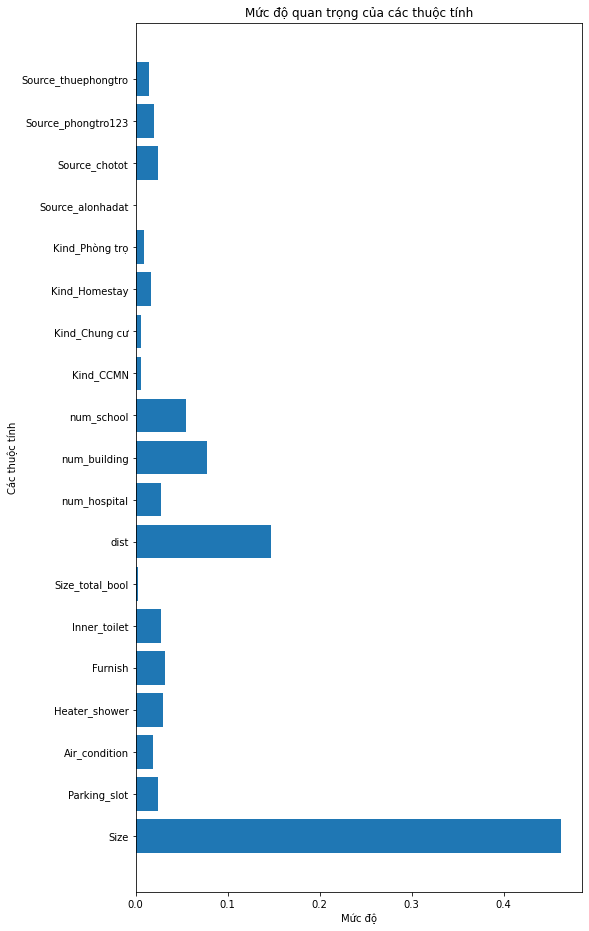

In [9]:
import matplotlib.pyplot as plt

features_name = data_processed.drop(['lat', 'lng', 'Price'], axis = 1).columns.values
n = len(features_name)
print(features_name)
plt.figure(figsize=(8,16))
plt.barh(range(n), rf.feature_importances_)
plt.yticks(range(n), features_name)
plt.title("Mức độ quan trọng của các thuộc tính")
plt.ylabel("Các thuộc tính")
plt.xlabel("Mức độ")

In [86]:
# corr = data_processed.corr()
# plt.figure(figsize=(30,30))
# sns.heatmap(corr, annot=True, cmap="Blues")